# 2-7. 프로젝트: ResNet Ablation Study

---
## 0) 라이브러리 버전 확인하기
---
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()



In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

데이터셋 준비

In [3]:
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteLA54P1/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

데이터 전처리

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
BATCH_SIZE = 32  # 256
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

---
## 1) ResNet 기본 블록 구성하기
---
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

In [8]:
#블록 생성
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [9]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

---
## 2) ResNet-34, ResNet-50 Complete Model
---
> ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

In [10]:
# 모델 생성 함수
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성합니다.
    # - is_ResNet=False 일 경우, Plain block 블록을 생성합니다.
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [11]:
ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

In [12]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [13]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

---
## 3) 일반 네트워크(plain network) 만들기
---


블록 코드 수정하기

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

전체 함수 코드 수정하기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [14]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        368

In [15]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        409

---
## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
---

In [16]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

In [17]:
BATCH_SIZE = 32  # 256
EPOCHS = 15  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9

In [18]:
# ResNet-34 학습
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
581/581 [==============================] - 139s 199ms/step - loss: 2.3476 - accuracy: 0.5558 - val_loss: 2.2608 - val_accuracy: 0.5318
Epoch 2/15
581/581 [==============================] - 115s 198ms/step - loss: 1.9269 - accuracy: 0.6270 - val_loss: 1.9754 - val_accuracy: 0.5280
Epoch 3/15
581/581 [==============================] - 115s 198ms/step - loss: 1.6504 - accuracy: 0.6733 - val_loss: 1.7537 - val_accuracy: 0.5801
Epoch 4/15
581/581 [==============================] - 115s 198ms/step - loss: 1.3925 - accuracy: 0.7446 - val_loss: 1.4050 - val_accuracy: 0.7019
Epoch 5/15
581/581 [==============================] - 115s 198ms/step - loss: 1.1942 - accuracy: 0.7836 - val_loss: 1.2148 - val_accuracy: 0.7274
Epoch 6/15
581/581 [==============================] - 115s 198ms/step - loss: 1.0225 - accuracy: 0.8232 - val_loss: 1.1709 - val_accuracy: 0.7155
Epoch 7/15
581/581 [==============================] - 115s 199ms/step - loss: 0.8785 - accuracy: 0.8575 - val_loss: 1.0056 -

In [19]:
# Plain-34 학습
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
581/581 [==============================] - 122s 190ms/step - loss: 2.1149 - accuracy: 0.5202 - val_loss: 1.9555 - val_accuracy: 0.5345
Epoch 2/15
581/581 [==============================] - 110s 189ms/step - loss: 1.8192 - accuracy: 0.5283 - val_loss: 1.7046 - val_accuracy: 0.5346
Epoch 3/15
581/581 [==============================] - 110s 189ms/step - loss: 1.6066 - accuracy: 0.5433 - val_loss: 1.5238 - val_accuracy: 0.5232
Epoch 4/15
581/581 [==============================] - 110s 189ms/step - loss: 1.4371 - accuracy: 0.5559 - val_loss: 1.3667 - val_accuracy: 0.5716
Epoch 5/15
581/581 [==============================] - 110s 189ms/step - loss: 1.3087 - accuracy: 0.5599 - val_loss: 1.2576 - val_accuracy: 0.5560
Epoch 6/15
581/581 [==============================] - 110s 189ms/step - loss: 1.2018 - accuracy: 0.5694 - val_loss: 1.1852 - val_accuracy: 0.4911
Epoch 7/15
581/581 [==============================] - 110s 189ms/step - loss: 1.1217 - accuracy: 0.5693 - val_loss: 1.0983 -

In [20]:
# ResNet-50 학습
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
581/581 [==============================] - 99s 143ms/step - loss: 5.8102 - accuracy: 0.5389 - val_loss: 5.0848 - val_accuracy: 0.5347
Epoch 2/15
581/581 [==============================] - 81s 140ms/step - loss: 4.6051 - accuracy: 0.6081 - val_loss: 4.1959 - val_accuracy: 0.6054
Epoch 3/15
581/581 [==============================] - 81s 140ms/step - loss: 3.8165 - accuracy: 0.6670 - val_loss: 3.5357 - val_accuracy: 0.6287
Epoch 4/15
581/581 [==============================] - 81s 140ms/step - loss: 3.2056 - accuracy: 0.6971 - val_loss: 2.9980 - val_accuracy: 0.6886
Epoch 5/15
581/581 [==============================] - 81s 140ms/step - loss: 2.7280 - accuracy: 0.7301 - val_loss: 2.5964 - val_accuracy: 0.6797
Epoch 6/15
581/581 [==============================] - 82s 141ms/step - loss: 2.3490 - accuracy: 0.7514 - val_loss: 2.6381 - val_accuracy: 0.5777
Epoch 7/15
581/581 [==============================] - 81s 140ms/step - loss: 2.0403 - accuracy: 0.7721 - val_loss: 2.1735 - val_ac

In [21]:
# Plain-50 학습
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
581/581 [==============================] - 177s 279ms/step - loss: 4.8961 - accuracy: 0.5017 - val_loss: 4.4033 - val_accuracy: 0.5071
Epoch 2/15
581/581 [==============================] - 160s 276ms/step - loss: 4.0243 - accuracy: 0.5225 - val_loss: 3.6805 - val_accuracy: 0.5334
Epoch 3/15
581/581 [==============================] - 160s 275ms/step - loss: 3.3941 - accuracy: 0.5327 - val_loss: 3.1308 - val_accuracy: 0.5310
Epoch 4/15
581/581 [==============================] - 160s 275ms/step - loss: 2.9077 - accuracy: 0.5281 - val_loss: 2.6986 - val_accuracy: 0.4920
Epoch 5/15
581/581 [==============================] - 160s 275ms/step - loss: 2.5254 - accuracy: 0.5409 - val_loss: 2.3741 - val_accuracy: 0.5331
Epoch 6/15
581/581 [==============================] - 160s 275ms/step - loss: 2.2207 - accuracy: 0.5386 - val_loss: 2.0934 - val_accuracy: 0.5374
Epoch 7/15
581/581 [==============================] - 160s 275ms/step - loss: 1.9744 - accuracy: 0.5606 - val_loss: 1.8717 -

ResNet/Plain-34, ResNet/Plain-50의 Training loss/accuracy 비교

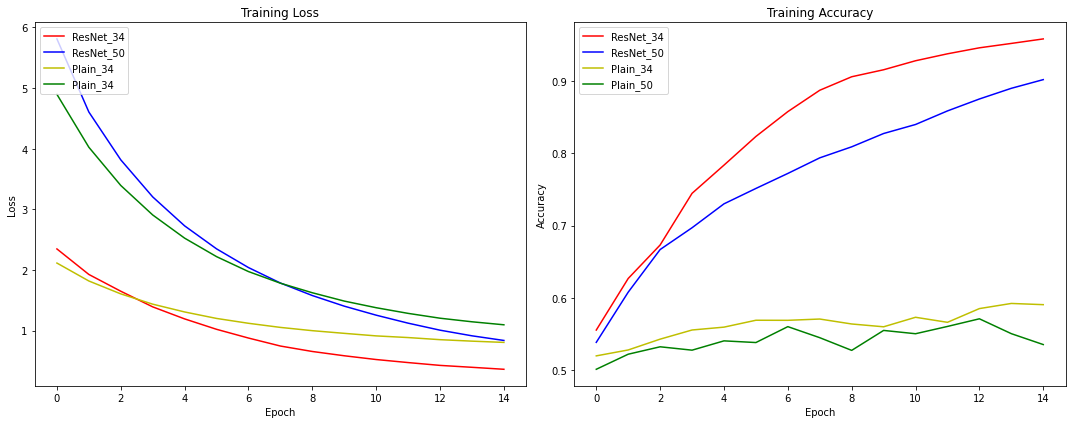

In [27]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_All.png')

plt.show()

ResNet-34, Plain-34의 Validation loss/accuracy 비교

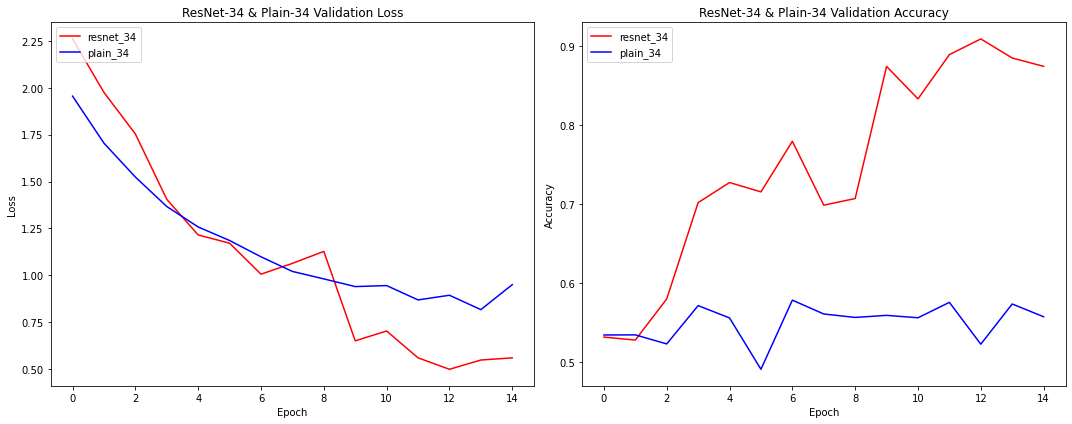

In [22]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_34.png')

plt.show()

ResNet-50, Plain-50의 Validation loss/accuracy 비교

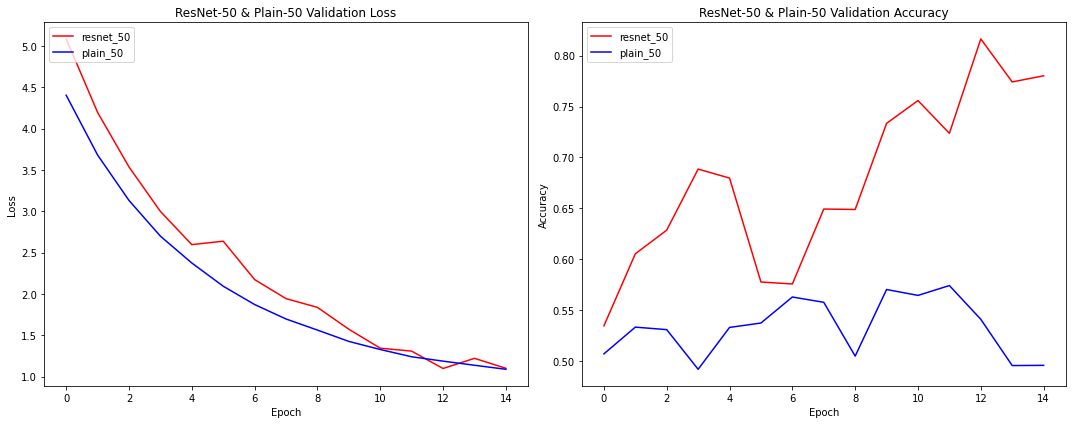

In [23]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_50.png')

plt.show()

In [25]:
model_result = {
    'ResNet-34': [
        round(np.array(history_resnet_34.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_34.history['val_accuracy']).mean(), 2)
    ],
    'Plain-34': [
        round(np.array(history_plain_34.history['val_loss']).mean(), 2),
        round(np.array(history_plain_34.history['val_accuracy']).mean(), 2)
    ],
    'ResNet-50': [
        round(np.array(history_resnet_50.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_50.history['val_accuracy']).mean(), 2)
    ],
    'Plain-50': [
        round(np.array(history_plain_50.history['val_loss']).mean(), 2),
        round(np.array(history_plain_50.history['val_accuracy']).mean(), 2)
    ],    
}

# 데이터 프레임 생성
df_model_result = pd.DataFrame(model_result, index=['Validation Loss', 'Validation Accuracy'])
df_model_result

,ResNet-34,Plain-34,ResNet-50,Plain-50
Validation Loss,1.10,1.17,2.31,2.06
Validation Accuracy,0.75,0.55,0.68,0.53


Validation Accuracy 기준 Ablation study 결과표

In [26]:
df_val_acc = pd.DataFrame(df_model_result.loc['Validation Accuracy'], columns=['Validation Accuracy'])
df_val_acc

,Validation Accuracy
ResNet-34,0.75
Plain-34,0.55
ResNet-50,0.68
Plain-50,0.53


---
## 5) Discussion
---


- 모델들에 대해서 epochs를 15로 동일하게 진행했는데, 다행히 예상했던 유의미한 결과를 얻을 수 있었다.
- 학습이 진행됨에 따라 ResNet과 Plain을 비교하여 Validation loss는 더 낮아지고 accuracy는 더 높아지는 것을 확인 할 수 있었다.
- layer가 쌓임에 따라 발생되는 degradation을 residual learning을 통해 해소하는 것을 확인 할 수 있었다.(ResNet과 Plain의 차이)
- 코드를 직접 구현하지 않았지만, 내용을 확인하며 단계별로 진행함으로써 풀잎에서도 공부했던 잔차학습과 관련된 내용을 직접 확인 할 수 있어 유익했다. 